Intuição de como o GPT funciona internamente:

A arquitetura do gpt tem como base o decoder da arquitetura transformer, lado direito da imagem abaixo:

<img src="https://miro.medium.com/v2/resize:fit:1400/1*Jwataw7ZYsHU0XvDA-jVqQ.png" alt="Transformer" width="30%" height="30%">

O fato do GPT usar o decoder somente, é devido ao foco do GPT prever o próximo token apenas cruzando o ultimo token com todos os anteriores exatamente como o decoder faz.

Para quem não esta por dentro do termo token, imagine os tokens como uma palavrao que é digitada pelo usuário na pergunta e cada palavra que é gerada na resposta pelo GPT.

Cada token tem um id unico em um vocabulario de palavras.

Na pratica vc defini o que é um token, ele pode ser uma subword como no GPT, exemplo para formar a palavra casamento poderia ser a junção de dois tokens (casa + mento), ou poderiamos ter um vocabulario estremamente simples e enxuto com apenas as letras do alfabeto + numeros + caracteres especiais, neste caso para escrever casamento seriam 9 tokens (c,a,s,a,m,e,n,t,o)

Referencias:
- link para o paper: https://arxiv.org/pdf/1706.03762.pdf

Primeiro passo é entender o conceito de similiaridade entre tokens e a representação do token o tal de "embedding"

In [ ]:
%pip install numpy
%pip install torch
%pip install scikit-learn
%pip install matplotlib

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Checa se tem device NVIDIA ou MPS (mac gpu)
if(torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# simplificar a visualização dos tensores
device = torch.device("cpu")

torch.set_default_device(device)

Primeiro vamos entender o que é Vocabulario, Token, Embedding:

<img src="https://arize.com/wp-content/uploads/2022/06/blog-king-queen-embeddings.jpg">


In [2]:
# criar nosso tokenizador

vocabulario = {
    0: "chocolate",
    1: "carne",
    2: "arroz",
    3: "caminhonete",
    4: "pickup",
    5: "carro"
}

# nosso espaco vetorial que ira representar o significado das palavras foi definico com 4 dimensoes []
# durante o treinamento nossa rede neural aprendeu:
# o que cada dimensao representa no significado de todas as palavras do vocabulario
embedding = {
    0: "comida",
    1: "sabor",
    2: "veiculo",
    3: "carga"
}

# para cada token no nosso vocabulario temos um vetor de embedding
# o valores deste vetor foram aprendidos durante o treinamento da rede neural
vocab_to_emb = {

    # chocolate..:              comida, sabor, veiculo, carga
    0          : torch.tensor([ 1.0   , 0.9  , 0.1    , 0.1  ]),

    # carne......:              comida, sabor, veiculo, carga
    1          : torch.tensor([ 1.0   , 0.8  , 0.01   , 0.01 ]),

    # arroz......:              comida, sabor, veiculo, carga
    2          : torch.tensor([ 1.0   , 0.7  , 0.01   , 0.01 ]),

    # caminhonete:              comida, sabor, veiculo, carga
    3          : torch.tensor([ 0.01  , 0.01 , 1.0    , 0.6 ]),

    # pickup.....:              comida, sabor, veiculo, carga
    4          : torch.tensor([ 0.01  , 0.01 , 1.0    , 0.5 ]),

    # carro......:              comida, sabor, veiculo, carga
    5          : torch.tensor([ 0.1   , 0.1  , 1.0    , 0.4 ])

}

[[-118.410286  185.81895 ]
 [-108.26642   190.1955  ]
 [-101.61034   193.06862 ]
 [ 134.79817  -118.14217 ]
 [ 134.39478  -125.3808  ]
 [ 133.77992  -136.41135 ]]


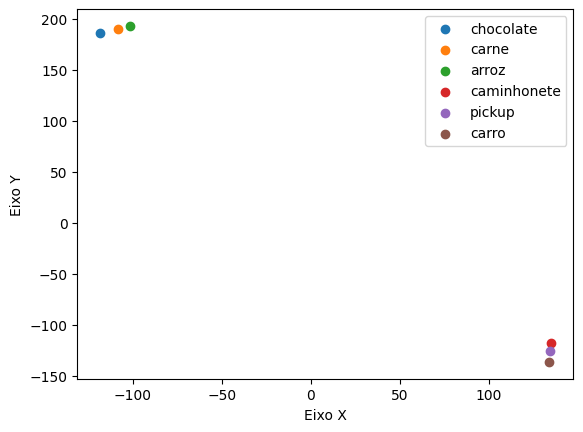

In [74]:
def plotar_tokens(vocabulario, vocab_to_emb, add=None, name=""):
    tensor_list = list(vocab_to_emb.values())
    if(add is not None):
        tensor_list.append(add)
    
    emb = torch.stack(tensor_list)

    # criar uma instancia do TSNE
    tsne = TSNE(n_components=2, perplexity=1)

    # Aplicar o TSNE ao vetor original
    emb_dimensao_reduzida = tsne.fit_transform(emb.cpu())
    print(emb_dimensao_reduzida)

    for token_id, token_emb in vocab_to_emb.items():
        # plotar o vetor reduzido (x, y)
        plt.scatter(emb_dimensao_reduzida[token_id][0], emb_dimensao_reduzida[token_id][1], label=vocabulario[token_id])
    
    if(add is not None):
        plt.scatter(emb_dimensao_reduzida[-1][0], emb_dimensao_reduzida[-1][1], label=name)

    # Definir rótulos dos eixos x e y
    plt.xlabel('Eixo X')
    plt.ylabel('Eixo Y')
    plt.legend()

    # Exibir o gráfico
    plt.show()

plotar_tokens(vocabulario, vocab_to_emb)

Como Calcular distancia ou similiaridade entre vetores:

- Euclidian Distance<br>
<img src="./img/euclidian.png" alt="euclidian" width="20%" height="20%">

- Dot Product Similarity<br>
<img src="./img/euclidian.png" alt="euclidian" width="20%" height="20%">

- Consine Similarity<br>
<img src="./img/euclidian.png" alt="euclidian" width="20%" height="20%">
1.0 = "0 grau" | 0.0 = "90 grau" | -1 = "180 grau"

In [4]:
def euclidian_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2))

def dot_product_similarity(a, b):
    return torch.dot(a, b)

def cosine_similarity(a, b):
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

print("Distancia euclidiana: quanto menor mais proximo")
print("Distancia euclidiana entre chocolate e chocolate..: ", euclidian_distance(vocab_to_emb[0], vocab_to_emb[0])) 
print("Distancia euclidiana entre chocolate e carne......: ", euclidian_distance(vocab_to_emb[0], vocab_to_emb[1])) 
print("Distancia euclidiana entre chocolate e arroz......: ", euclidian_distance(vocab_to_emb[0], vocab_to_emb[2]))
print("Distancia euclidiana entre chocolate e caminhonete: ", euclidian_distance(vocab_to_emb[0], vocab_to_emb[3]))
print("Distancia euclidiana entre chocolate e pickup.....: ", euclidian_distance(vocab_to_emb[0], vocab_to_emb[4]))
print("Distancia euclidiana entre chocolate e carro......: ", euclidian_distance(vocab_to_emb[0], vocab_to_emb[5]))
print()
print("Similiaridade dot_product: quanto maior mais similar")
print("Similiaridade dot_product entre chocolate e chocolate..: ", dot_product_similarity(vocab_to_emb[0], vocab_to_emb[0])) 
print("Similiaridade dot_product entre chocolate e carne......: ", dot_product_similarity(vocab_to_emb[0], vocab_to_emb[1])) 
print("Similiaridade dot_product entre chocolate e arroz......: ", dot_product_similarity(vocab_to_emb[0], vocab_to_emb[2]))
print("Similiaridade dot_product entre chocolate e caminhonete: ", dot_product_similarity(vocab_to_emb[0], vocab_to_emb[3]))
print("Similiaridade dot_product entre chocolate e pickup.....: ", dot_product_similarity(vocab_to_emb[0], vocab_to_emb[4]))
print("Similiaridade dot_product entre chocolate e carro......: ", dot_product_similarity(vocab_to_emb[0], vocab_to_emb[5]))
print()
print("Similiaridade coseno: quanto maior mais similar")
print("Similiaridade coseno entre chocolate e chocolate..: ", cosine_similarity(vocab_to_emb[0], vocab_to_emb[0])) 
print("Similiaridade coseno entre chocolate e carne......: ", cosine_similarity(vocab_to_emb[0], vocab_to_emb[1])) 
print("Similiaridade coseno entre chocolate e arroz......: ", cosine_similarity(vocab_to_emb[0], vocab_to_emb[2]))
print("Similiaridade coseno entre chocolate e caminhonete: ", cosine_similarity(vocab_to_emb[0], vocab_to_emb[3]))
print("Similiaridade coseno entre chocolate e pickup.....: ", cosine_similarity(vocab_to_emb[0], vocab_to_emb[4]))
print("Similiaridade coseno entre chocolate e carro......: ", cosine_similarity(vocab_to_emb[0], vocab_to_emb[5]))


Distancia euclidiana: quanto menor mais proximo
Distancia euclidiana entre chocolate e chocolate..:  tensor(0.)
Distancia euclidiana entre chocolate e carne......:  tensor(0.1619)
Distancia euclidiana entre chocolate e arroz......:  tensor(0.2371)
Distancia euclidiana entre chocolate e caminhonete:  tensor(1.6829)
Distancia euclidiana entre chocolate e pickup.....:  tensor(1.6560)
Distancia euclidiana entre chocolate e carro......:  tensor(1.5330)

Similiaridade dot_product: quanto maior mais similar
Similiaridade dot_product entre chocolate e chocolate..:  tensor(1.8300)
Similiaridade dot_product entre chocolate e carne......:  tensor(1.7220)
Similiaridade dot_product entre chocolate e arroz......:  tensor(1.6320)
Similiaridade dot_product entre chocolate e caminhonete:  tensor(0.1790)
Similiaridade dot_product entre chocolate e pickup.....:  tensor(0.1690)
Similiaridade dot_product entre chocolate e carro......:  tensor(0.3300)

Similiaridade coseno: quanto maior mais similar
Similia

Agora vamos entender como a arquitetura do decoder do transforme funciona para prever o proximo token
Primeiro passo é entender o mecanismo de self-attention:
 - Vou explicar de um modo siplificado, a idéia aqui é entender a intuição por traz do mecanismo de self-attention

<img src="./img/self-attention.png" alt="Self-Attention" width="60%" height="60%">

Neste exemplo iremos mostrar como o cruzamento de tokens acontece e como isto afeta a previsao da próxima palavra

Bom vamos cruzar estes 2 tokens:
carro + chocolate

![imagem](https://st2.depositphotos.com/1362337/10378/i/380/depositphotos_103789698-stock-photo-little-chocolate-retro-pickup-truck.jpg)

Neste exemplo não estamos adicionando os pesos treinaveis para simplicar o entendimento

In [12]:
# tokens
# token: id: 0, value: chocolate
# token: id: 5, value: carro
emb_chocolate = vocab_to_emb[0]
emb_carro = vocab_to_emb[5]

# sequencia = carro + chocolate
# query =  [chocolate] (ultimo token)
query = emb_carro

# keys = [carro, chocolate]
keys = torch.stack((emb_chocolate,emb_carro))

# values = [carro, chocolate]
values = torch.stack((emb_chocolate,emb_carro))

print(f"token sequence: 'carro chocolate'")
print(f"query[chocolate]:\n{query}\nUltimo token da sequencia\n")
print(f"keys[carro, chocolate]:\n{keys}\n")
print(f"values[carro, chocolate]:\n{values}\n")

plotar_tokens(vocabulario, vocab_to_emb)


token sequence: 'carro chocolate'
query[chocolate]:
tensor([0.1000, 0.1000, 1.0000, 0.4000])
Ultimo token da sequencia

keys[carro, chocolate]:
tensor([[1.0000, 0.9000, 0.1000, 0.1000],
        [0.1000, 0.1000, 1.0000, 0.4000]])

values[carro, chocolate]:
tensor([[1.0000, 0.9000, 0.1000, 0.1000],
        [0.1000, 0.1000, 1.0000, 0.4000]])



# Dot Product

<img src="./img/dotproductvisual.png" alt="dot product" width="20%" height="20%">


In [90]:
# Embeddings
# keys[0] = emb_chocolate
# keys[1] = emb_carro

# values[0] = emb_chocolate
# values[1] = emb_carro

print("---------- query: chocolate -> key/value: chocolate ---------- ")
print(f"query..: {query}\nkeys...: {keys[1]}")

score_chocolate_chocolate = query * keys[1] # query = chocolate & keys[1] = chocolate
print(f"q*k....: {score_chocolate_chocolate}")

score_chocolate_chocolate = torch.sum(score_chocolate_chocolate)
print(f"soma...: {score_chocolate_chocolate}")

print("\n---------- query: chocolate -> key/value: carro ---------- ")
print(f"query..: {query}\nkeys...: {keys[0]}")

score_chocolate_carro = query * keys[0] # query = chocolate & keys[0] = carro
print(f"q*k....: {score_chocolate_carro}")

score_chocolate_carro = torch.sum(score_chocolate_carro)
print(f"soma...: {score_chocolate_carro}")

print("\n---------- softmax [chocolate_chocolate, chocolate_carro] ---------- ")
scores = F.softmax(torch.stack((score_chocolate_chocolate, score_chocolate_carro)), dim=0)
print(f"scores.: {scores}")

print("\n---------- vetores_de_saida_contextualizado (parciais: % de cada token) ---------- ")

saida_chocolate_chocolate = scores[0] * values[1] # scores[0] = chocolate_chocolate * value[1] = chocolate
print(f"chocolate................: {values[1]}")
print(f"multiplicado_por.........: {scores[0]}")
print(f"saida_chocolate_chocolate: {saida_chocolate_chocolate}")

print()

saida_chocolate_carro = scores[1] * values[0] # scores[1] = chocolate_carro * value[0] = carro
print(f"carro....................: {values[0]}")
print(f"multiplicado_por.........: {scores[1]}")
print(f"saida_chocolate_carro....: {saida_chocolate_carro}")

print("\n---------- vetor_de_saida_contextualizado (final: soma das parciais) ---------- ")
print(f"saida_chocolate_chocolate (parcial): {saida_chocolate_chocolate}")
print(f"saida_chocolate_carro.....(parcial): {saida_chocolate_carro}")
vetor_contextualizado = saida_chocolate_chocolate + saida_chocolate_carro
print(f"Vetor contextualizado.....(final)..: {vetor_contextualizado}")
print("Embedding..........................:        [comida, sabor, veiculo, carga]")


---------- query: chocolate -> key/value: chocolate ---------- 
query..: tensor([0.1000, 0.1000, 1.0000, 0.4000])
keys...: tensor([0.1000, 0.1000, 1.0000, 0.4000])
q*k....: tensor([0.0100, 0.0100, 1.0000, 0.1600])
soma...: 1.1799999475479126

---------- query: chocolate -> key/value: carro ---------- 
query..: tensor([0.1000, 0.1000, 1.0000, 0.4000])
keys...: tensor([1.0000, 0.9000, 0.1000, 0.1000])
q*k....: tensor([0.1000, 0.0900, 0.1000, 0.0400])
soma...: 0.32999998331069946

---------- softmax [chocolate_chocolate, chocolate_carro] ---------- 
scores.: tensor([0.7006, 0.2994])

---------- vetores_de_saida_contextualizado (parciais: % de cada token) ---------- 
chocolate................: tensor([0.1000, 0.1000, 1.0000, 0.4000])
multiplicado_por.........: 0.7005671858787537
saida_chocolate_chocolate: tensor([0.0701, 0.0701, 0.7006, 0.2802])

carro....................: tensor([1.0000, 0.9000, 0.1000, 0.1000])
multiplicado_por.........: 0.2994329035282135
saida_chocolate_carro....: tens

In [101]:
print("\n---------- Simulando a aplicação de pesos treinados ---------- ")
print("Embedding.............................:        [comida, sabor, veiculo, carga]")
print(f"Vetor contextualizado.....(final).....: {vetor_contextualizado}")
pesos = torch.tensor([2.0, 2.2, 0.6, 0.01])
print(f"Pesos para multiplica.................: {pesos}")

saida_modelo = vetor_contextualizado * pesos
print(f"Saida modelo para 'carro + chocolate'.: {saida_modelo}")


---------- Simulando a aplicação de pesos treinados ---------- 
Embedding.............................:        [comida, sabor, veiculo, carga]
Vetor contextualizado.....(final).....: tensor([0.3695, 0.3395, 0.7305, 0.3102])
Pesos para multiplica.................: tensor([2.0000, 2.2000, 0.6000, 0.0100])
Saida modelo para 'carro + chocolate'.: tensor([0.7390, 0.7470, 0.4383, 0.0031])


# Entendo como o Decoder do Transformer trata uma sequencia de tokens para prever o proximo

Para a sequencia de tokens:
carro chocolate

Agora temos a representacao mais contextualizada para o ultimo token "chocolate".
- onde a nova composicao é basicamente:
    - 30% do token carro
    - 70% do token chocolate

No exemplo anterior, apenas calculamos a saida do vetor contextualizado do ultimo token "chocolate" na sequencia "carro chocolate"

Vamos agora explorar um exemplo de uma sequencia de tokens com processamento completo
Imagine nossa rede neural agora com o seguinte vocabulario:
- [eu, dei, racao, pro, meu, gato, cachorro, peixe]

E estamos passando pelo decoder uma sequencia de tokens como esta:
- eu dei racao pro meu

Teremos os seguintes vetores de saida (S):
- S0 = eu                   -> query: eu    -> (eu    x eu   )
- S1 = eu dei               -> query: dei   -> (dei   x dei  ), (dei   x eu   )
- S2 = eu dei racao         -> query: racao -> (racao x racao), (racao x dei  ), (racao x eu   )
- S3 = eu dei racao pro     -> query: pro   -> (pro   x pro  ), (pro   x racao), (pro   x dei  ), (pro x eu )
- S4 = eu dei racao pro meu -> query: meu   -> (meu   x meu  ), (meu   x pro  ), (meu   x racao), (meu x dei), (meu x eu)

A rede neural utiliza este contexto para prever o proximo token, sendo basicamente a cada passada na rede um vetor do vocabulario com a probabilidade do proximo token:
- Exemplo para o primeiro token
    - Vetores de saida (contexto) -> probabilidade do proximo token (previsao)
    - S0 -> usado para prever T1
        - [eu......: 0.01]
        - [dei.....: 0.93]
        - [racao...: 0.01]
        - [pro.....: 0.01]
        - [meu.....: 0.01]
        - [gato....: 0.01]
        - [cachorro: 0.01]
        - [peixe...: 0.01]

- S1 ... S3 -> [...] ... [...]

- Exemplo para o ultimo token: "eu dei racao pro meu ..."
    - S4 -> usado para prever T5
    - [eu......: 0.01]
    - [dei.....: 0.01]
    - [racao...: 0.01]
    - [pro.....: 0.01]
    - [meu.....: 0.01]
    - [gato....: 0.35]
    - [cachorro: 0.40]
    - [peixe...: 0.20]


# Prevendo o proximo token


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)

# Gerando a camada final que converte Sx em probabilidades de proximo token

vocabulario = {0: "eu", 1: "dei", 2: "racao", 3: "pro", 4: "meu", 5: "gato", 6: "cachorro", 7: "peixe"}
vocab_size = len(vocabulario) # len == 8 -> [eu, dei, racao, pro, meu, gato, cachorro, peixe]
embedding_size = 15 # tamanho da dimensao que contem a representação do token
num_tokens = 1

print(vocabulario)
print()

# Saida da camada transformer: para S4 (token "meu" contextualizado com "eu + dei + racao + pro + meu")
# sequencia de tokens: "eu  dei racao pro meu" [next token]
# sequencia de tokens: "[0] [1] [2]   [3] [4]" [next token]

saida_decoder = torch.rand(num_tokens, embedding_size) # exemplo de uma saida da camada transformer para S4

# Definindo a camada linear para redução de dimensionalidade
# de embedding size para vocab size
camada_linear_final = nn.Linear(embedding_size, vocab_size)
print("Camada Linear que reduz de embedding_size para vocab_size")
print(camada_linear_final)


# Setando dados para treinamento:

# Definindo a função de perda
criterion = nn.CrossEntropyLoss()

# Definindo o otimizador
optimizer = optim.Adam(camada_linear_final.parameters(), lr=0.01)

{0: 'eu', 1: 'dei', 2: 'racao', 3: 'pro', 4: 'meu', 5: 'gato', 6: 'cachorro', 7: 'peixe'}

Camada Linear que reduz de embedding_size para vocab_size
Linear(in_features=15, out_features=8, bias=True)


# Forward pass

In [10]:
# Passando pelo modelo (camada final de output)
# Gerando logits
logits = camada_linear_final(saida_decoder)
print("\nLogits: gerado com base no tamanho do vocab size")
print(logits)

# Aplicando a softmax para obter probabilidades
probabilidade = nn.Softmax(dim=1)(logits)
print("\nProbabilidade")
print(probabilidade)
print()

# Obtendo os índices máximos (índices de vocabulário) para cada token
token_indice_previsto = torch.argmax(probabilidade, dim=1).item()

print("-------------------------------------------")
print("eu dei racao pro meu [next token]")
print(f"Token previsto: {token_indice_previsto} -> {vocabulario[token_indice_previsto]}")

# definir targets
target = torch.tensor([6])
print(f"Token correto.: {target.item()} -> {vocabulario[target.item()]}")


Logits: gerado com base no tamanho do vocab size
tensor([[-0.0424, -0.2821,  0.0872,  0.2097, -0.0489, -0.0543,  0.2985, -0.4141]],
       grad_fn=<AddmmBackward0>)

Probabilidade
tensor([[0.1206, 0.0949, 0.1373, 0.1552, 0.1199, 0.1192, 0.1696, 0.0832]],
       grad_fn=<SoftmaxBackward0>)

-------------------------------------------
eu dei racao pro meu [next token]
Token previsto: 6 -> cachorro
Token correto.: 6 -> cachorro


# Treinando o Modelo de predicao

In [9]:
# Cálculo da loss
loss = criterion(logits, target)

# Backpropagation
optimizer.zero_grad() # Zera os gradientes acumulados
loss.backward()      # Calcula os gradientes
optimizer.step()     # Atualiza os pesos

print("Loss:", loss.item())

Loss: 1.893663763999939


# Camada Linear manual

In [26]:
batch_size = 1
seq_len = 2
embedding_size = 4 # in_features
out_features = embedding_size * 2 # out_features, escalando para 2x o tamanho do embedding

x = torch.randn(batch_size,seq_len,embedding_size)
pesos = torch.randn(out_features, embedding_size)
bias = torch.randn(1)

print("Entrada do modelo:")
print(x)
print(x.size())
print()
print("Pesos do modelo:")
print(pesos)
print(pesos.size())
print()
print("Bias do modelo:")
print(bias)
print(bias.size())

Entrada do modelo:
tensor([[[ 0.5161,  0.1998, -0.2533,  0.4222],
         [ 0.8155,  0.7504, -0.5165,  0.5845]]])
torch.Size([1, 2, 4])

Pesos do modelo:
tensor([[ 1.0184, -0.4169, -0.0308, -1.4795],
        [-0.4946,  0.3732,  1.7536, -1.3083],
        [-0.2934,  0.4649,  0.5762,  0.4427],
        [-0.0079, -0.3447,  0.0216,  0.2976],
        [ 1.4353,  0.2518,  0.7408,  1.4431],
        [-0.2053,  1.0915,  0.4405, -0.2802],
        [ 0.7029, -0.6675,  0.1254,  0.7900],
        [-0.0095, -0.8578,  0.2134,  1.6378]])
torch.Size([8, 4])

Bias do modelo:
tensor([-1.4582])
torch.Size([1])


In [31]:
transposta_pesos = pesos.transpose(0,1)
print()
print("x:")
print(x)
print(x.size())
print()
print("Transposta pesos:")
print(transposta_pesos)
print(transposta_pesos.size())

saida = x @ transposta_pesos

print()
print("saida:")
print(saida)
print(saida.size())

saida = saida + bias



x:
tensor([[[ 0.5161,  0.1998, -0.2533,  0.4222],
         [ 0.8155,  0.7504, -0.5165,  0.5845]]])
torch.Size([1, 2, 4])

Transposta pesos:
tensor([[ 1.0184, -0.4946, -0.2934, -0.0079,  1.4353, -0.2053,  0.7029, -0.0095],
        [-0.4169,  0.3732,  0.4649, -0.3447,  0.2518,  1.0915, -0.6675, -0.8578],
        [-0.0308,  1.7536,  0.5762,  0.0216,  0.7408,  0.4405,  0.1254,  0.2134],
        [-1.4795, -1.3083,  0.4427,  0.2976,  1.4431, -0.2802,  0.7900,  1.6378]])
torch.Size([4, 8])

saida:
tensor([[[-0.1745, -1.1772, -0.0176,  0.0473,  1.2127, -0.1178,  0.5312,
           0.4611],
         [-0.3312, -1.7936,  0.0707, -0.1023,  1.8203,  0.2603,  0.4694,
           0.1956]]])
torch.Size([1, 2, 8])


# Gerando um embedding de uma sentença

No cenário onde temos um sentença

"eu sou bruno"

Token[0] T0: eu
Token[1] T1: sou
Token[2] T2: bruno

Queremos salvar na vector db uma única sentença que representa o contexto semantico dos 3 tokens


In [35]:
# Saida do decoder
S1 = torch.tensor([0.1, 0.9, 0.2, 0.4])
S2 = torch.tensor([0.2, 0.1, 0.8, 0.7])
S3 = torch.tensor([0.3, 0.3, 0.7, 0.5])
sentence = torch.stack((S1, S2, S3))
print(sentence)

# Max Pooling
max_pooling, _  = torch.max(sentence, dim=0)
print(max_pooling)

# Mean Pooling
mean_pooling = torch.mean(sentence, dim=0)
print(mean_pooling)



tensor([[0.1000, 0.9000, 0.2000, 0.4000],
        [0.2000, 0.1000, 0.8000, 0.7000],
        [0.3000, 0.3000, 0.7000, 0.5000]])
tensor([0.3000, 0.9000, 0.8000, 0.7000])
tensor([0.2000, 0.4333, 0.5667, 0.5333])
